We're going to follow a modified version of the corrections attempted in `Y1_logdist_correct.ipynb`, but we are going to combine the luminosity function and size function.

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, join
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.modeling.models import Schechter1D
from astropy import units as u

from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import norm, binned_statistic, lognorm
from scipy.integrate import quad

import pickle

from tqdm import tqdm

import emcee

from corner import corner

import matplotlib.pyplot as plt

# Import data

## Y1 data

In [2]:
filename = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits'

hdul = fits.open(filename)
SGA_TF = Table(hdul[1].data)
hdr = hdul[0].header
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005

## SGA catalog

In [3]:
SGA_path = '/global/cfs/cdirs/cosmo/data/sga/2020/'
SGA_filename = SGA_path + 'SGA-2020.fits'

SGA = Table.read(SGA_filename, 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## PV Survey TF targets

In [4]:
pv_tf  = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_tf.fits')

pv_tf[:5]

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID,SGA_ID
int64,int32,bytes8,float64,float64,float32,float32,float32,bool,bytes3,int32,int64,int64
262,520796,2267p350,226.62204270638287,34.98227660676318,0.0,0.0,2015.5,True,TFT,1,1,1006008
262,520796,2267p350,226.62323955692426,34.98099178744529,0.0,0.0,2015.5,False,TFT,2,2,1006008
262,520796,2267p350,226.62443636990747,34.97970695638398,0.0,0.0,2015.5,True,TFT,1,3,1006008
2738,514840,2263p337,226.40142777879575,33.68537046528162,0.0,0.0,2015.5,True,TFT,1,1,4331
2738,514840,2263p337,226.40426477759235,33.68450278837041,0.0,0.0,2015.5,False,TFT,2,2,4331


In [5]:
# We just want a table with the galaxies targeted for the TF sample
TF_target_SGAids, target_indices = np.unique(pv_tf['SGA_ID'], return_index=True)

SGA_targets = join(SGA, pv_tf[['SGA_ID']][target_indices], keys='SGA_ID')

# 1. Compute the luminosity and size functions

We'll use the target sample to build these two functions, since that will include all morphological and other selection effects.

## Compute the physical size of the galaxies

We need to compute the physical size of the galaxies so that we can determine to what maximum distance the galaxy would have been included in the SGA (since it is size-limited).

**Note:** We will need to use `Z_LEDA` for the SGA because not all the SGA galaxies have been observed by DESI

In [6]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [7]:
SGA_TF['DIST_DESI_CMB'] = Distance(z=np.abs(SGA_TF['Z_DESI_CMB']), cosmology=Planck18_h)

SGA_TF['D26_kpc'] = 2*SGA_TF['DIST_DESI_CMB'].to('kpc')*np.tan(0.5*(SGA_TF['D26']*u.arcmin))

SGA_TF['DIST_MAX'] = 0.5*SGA_TF['D26_kpc']/np.tan(0.1*u.arcmin)


# Mask redshift values of -99 and -1 (= missing)
SGA_targets['Z_LEDA'][SGA_targets['Z_LEDA'] < 1e-4] = np.nan

dist_targets = Distance(z=np.abs(SGA_targets['Z_LEDA']), cosmology=Planck18_h)

SGA_targets['D26_kpc'] = 2*dist_targets.to('kpc')*np.tan(0.5*SGA_targets['D26']*u.arcmin)

SGA_targets['DIST_MAX'] = 0.5*SGA_targets['D26_kpc']/np.tan(0.1*u.arcmin)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


## Compute the absolute magnitude of the galaxies

In [8]:
SGA_targets['MU_ZLEDA'] = Planck18_h.distmod(SGA_targets['Z_LEDA'])

SGA_targets['R_ABSMAG_SB26'] = SGA_targets['R_MAG_SB26'] - SGA_targets['MU_ZLEDA'].value

## Parameterize the luminosity function

Schechter function:
\begin{equation}
  \Phi (M_r) = 0.4 \ln 10 \, \Phi^* 10^{0.4(M^* - M_r)(\alpha + 1)} \exp \left[ -10^{0.4(M^* - M_r)} \right]
\end{equation}

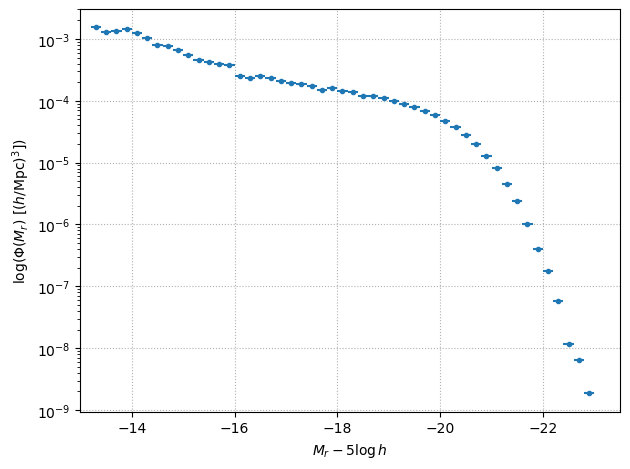

In [9]:
Mr_binwidth = 0.2
Mr_bins = np.arange(-23, -13, Mr_binwidth)

mag_func, bin_edges = np.histogram(SGA_targets['R_ABSMAG_SB26'], 
                                   bins=Mr_bins, 
                                   weights=SGA_targets['DIST_MAX'].to('Mpc').value**-3
                                  )

plt.figure(tight_layout=True)

plt.errorbar(bin_edges[:-1] + 0.5*Mr_binwidth, 
             mag_func, 
             xerr=0.5*Mr_binwidth, 
             # yerr=1/np.sqrt(mag_func), 
             fmt='.')

plt.yscale('log')

plt.xlim([-13, -23.5])

plt.grid(ls=':')

plt.xlabel('$M_r - 5\log h$')
plt.ylabel(r'log($\Phi(M_r)$ [($h$/Mpc)$^3$])');

In [10]:
def logL_Schechter1D(params, n, x):
    '''
    Log-likelihood of the Schechter function in magnitude space

    PARAMETERS
    ==========
    params : list or ndarray
        List of three parameters: scale factor, slope, and knee
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n
    dx : float or ndarray
        Bin width used to construct the histogrammed counts

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    model = Schechter1D(10**params[0]*(u.Mpc**-3), params[1], params[2]) + Schechter1D(10**params[3]*(u.Mpc**-3), params[4], params[5])
    lambda1 = model(x).value

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))
    # return -0.5*np.sum((n - lambda1)**2)


def nlogL_Schechter1D(params, n, x):
    '''Negative log likelihood, for minimizers'''
    return -logL_Schechter1D(params, n, x)

In [11]:
bounds = [[-5, -2], [-21, -19], [-2, 0]]
bounds2 = [[-5, -2], [-18, -14], [-2, 0]]

# p0 = [np.random.uniform(bounds[0][0], bounds[0][1]), 
#       np.random.uniform(bounds[1][0], bounds[1][1]), 
#       np.random.uniform(bounds[2][0], bounds[2][1])]

p0 = [-4, -20.4, -1.3]
p0_2 = [-4, -17, -1.7]

result = minimize(nlogL_Schechter1D, 
                  p0 + p0_2, 
                  args=(mag_func, bin_edges[:-1] + 0.5*Mr_binwidth), 
                  bounds=bounds + bounds2)

result

      fun: 0.12038863824564372
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.15042483e-06, -4.57273070e-06, -7.39686095e-06,  1.23095979e-06,
       -1.73888667e-06,  2.18575157e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 406
      nit: 53
     njev: 58
   status: 0
  success: True
        x: array([ -3.96500563, -20.27360007,  -1.26479687,  -2.70231409,
       -14.17868194,  -0.77069959])

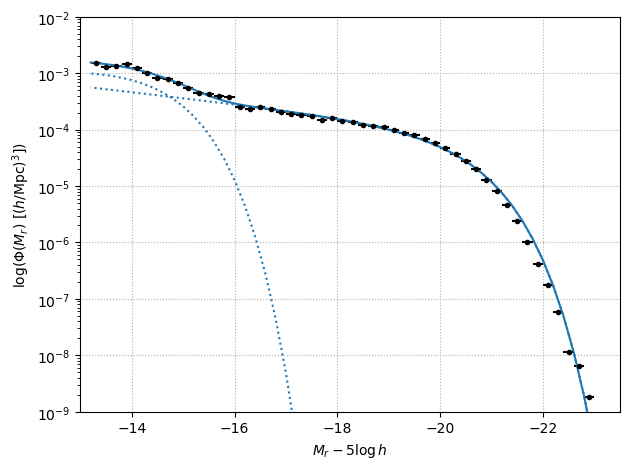

In [12]:
plt.figure(tight_layout=True)

plt.errorbar(bin_edges[:-1] + 0.5*Mr_binwidth, 
             mag_func, 
             xerr=0.5*Mr_binwidth, 
             # yerr=1/np.sqrt(mag_func), 
             c='k',
             fmt='.')

# Actual fit
model = Schechter1D(10**result.x[0]*(u.Mpc**-3), result.x[1], result.x[2])
model2 = Schechter1D(10**result.x[3]*(u.Mpc**-3), result.x[4], result.x[5])
plt.plot(bin_edges, model(bin_edges) + model2(bin_edges), c='tab:blue')
plt.plot(bin_edges, model(bin_edges), c='tab:blue', ls=':')
plt.plot(bin_edges, model2(bin_edges), c='tab:blue', ls=':')
'''
# Manual fit
model = Schechter1D(10**-4*(u.Mpc**-3), -20.4, -1.3)
model2 = Schechter1D(10**-4*(u.Mpc**-3), -17, -1.7)
plt.plot(bin_edges, model(bin_edges) + model2(bin_edges), c='tab:orange')
plt.plot(bin_edges, model(bin_edges), c='tab:orange', ls=':')
plt.plot(bin_edges, model2(bin_edges), c='tab:orange', ls=':')
'''
plt.yscale('log')

plt.xlim([-13, -23.5])
plt.ylim([10**-9, 10**-2])

plt.grid(ls=':')

plt.xlabel('$M_r - 5\log h$')
plt.ylabel(r'log($\Phi(M_r)$ [($h$/Mpc)$^3$])');

## Parameterize the size function

From [Shen et al. (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..978S/abstract), the size function within a luminosity bin can be parameterized by a log-normal function:

\begin{equation}
  P(R|L) \, dR = \frac{1}{\sqrt{2\pi} \sigma_{\ln R}} \exp{ \left[ -\frac{\ln^2 \left( \frac{R}{\overline{R}} \right)}{2\sigma^2_{\ln R}} \right] } \frac{dR}{R}
\end{equation}

where $\overline{R}$ is the median size and $\sigma_{\ln R}$ is the dispersion.  (I.e., in bins of absolute magnitde, what is the size distribution?)

In [21]:
def logL_lognorm(params, n, x):
    '''
    Log-likelihood of the log-normal function

    PARAMETERS
    ==========
    params : list or ndarray
        List of three parameters: width, location, and scale
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    lambda1 = lognorm.pdf(x, *params)

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def nlogL_lognorm(params, n, x):
    '''Negative log likelihood, for minimizers'''
    return -logL_lognorm(params, n, x)

In [13]:
# Determine the absolute magnitude bin within which each galaxy falls
mag_indices = np.digitize(SGA_targets['R_ABSMAG_SB26'], Mr_bins)

In [14]:
N_bins = len(bin_edges) - 1
N_bins

49

[[0, 10], [5.011872336272725, 50.11872336272725], [0, 10]]
[0.573553932076873, 12.589254117941687, 1]
0.33833706818189213
      fun: 0.0401026142616642
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.20989375e-05,  3.39478417e-05, -4.32001657e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 31
     njev: 52
   status: 0
  success: True
        x: array([1.76239738e+00, 1.15420156e+01, 3.80172190e-03])


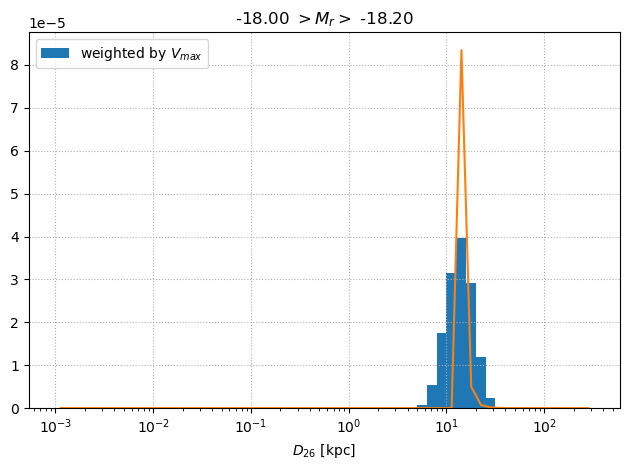

In [50]:
# Plot the size distribution within each luminosity bin
D26kpc_bins = np.logspace(-3, 2.5, 56)
D26kpc_binwidth = D26kpc_bins[1:] - D26kpc_bins[:-1]
D26kpc_centers = D26kpc_bins[:-1] + 0.5*D26kpc_binwidth

# fig, axes = plt.subplots(7, 7, figsize=(15, 15), sharex=True, sharey=True, tight_layout=True)
fig, ax = plt.subplots(1,1, tight_layout=True)

i = j = 3
# for i in range(axes.shape[0]):
#     for j in range(axes.shape[1]):

# ax = axes[i,j]

lum_bin = i*7 + j

N,_ = np.histogram(SGA_targets['D26_kpc'][mag_indices == lum_bin], 
                   bins=D26kpc_bins)
N_corr,_ = np.histogram(SGA_targets['D26_kpc'][mag_indices == lum_bin], 
                        bins=D26kpc_bins, 
                        weights=SGA_targets['DIST_MAX'][mag_indices == lum_bin].to('Mpc').value**-3)

# ax.stairs(N_corr/np.sum(N_corr), edges=D26kpc_bins, fill=True, label='weighted by $V_{max}$')
ax.stairs(N_corr, edges=D26kpc_bins, fill=True, label='weighted by $V_{max}$')
# ax.stairs(N/np.sum(N), edges=D26kpc_bins, label='unweighted')
# ax.hist(SGA_targets['D26_kpc'][mag_indices == lum_bin], D26kpc_bins, histtype='step')
# ax.hist(SGA_targets['D26_kpc'][mag_indices == lum_bin], D26kpc_bins, weights=SGA_targets['DIST_MAX'][mag_indices == lum_bin].to('Mpc').value**-3)

# most populus bin
Rbar0_i = np.argmax(N_corr)
Rbar0 = D26kpc_bins[Rbar0_i]

# standard deviation in ln(R)
sig_lnR0 = np.std(np.log(SGA_targets['D26_kpc'][mag_indices == lum_bin]))
# print(sig_lnR0)

non_empty = N_corr > 0

bounds_lognorm = [[0, 10], 
                  [np.nanmin(D26kpc_bins[:-1][non_empty]), np.nanmax(D26kpc_bins[1:][non_empty])],
                  [0, 10]]
print(bounds_lognorm)

p0_lognorm = [2*sig_lnR0, Rbar0, 1]
print(p0_lognorm)

print(nlogL_lognorm(p0_lognorm, N_corr, D26kpc_centers))

result = minimize(nlogL_lognorm, 
                  p0_lognorm,
                  args=(N_corr, D26kpc_centers), 
                  bounds=bounds_lognorm)
print(result)

ax.plot(D26kpc_centers, lognorm.pdf(D26kpc_centers, *result.x))
# ax.plot(D26kpc_centers, lognorm.pdf(D26kpc_centers, sig_lnR0, Rbar0))

ax.grid(ls=':')

ax.set(xscale='log', 
       title='{:.2f} $> M_r >$ {:.2f}'.format(bin_edges[lum_bin+1], bin_edges[lum_bin])
      )

# if i == axes.shape[0] - 1:
ax.set(xlabel='$D_{26}$ [kpc]')

# if lum_bin == 0:
ax.legend()

# if j == 0:
#     ax.set(ylabel='galaxy count')